In [29]:
import config
import dr_methods as drm
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.transforms as tr
import niftiutils.visualization as vis
import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from os.path import *
import pandas as pd
import shutil
import re
import random
import seg_methods as sm
import time
import voi_methods as vm
import operator
%matplotlib inline

import manifold as mani
import keras.layers as layers

In [148]:
importlib.reload(config)
C = config.Config()

In [169]:
importlib.reload(mani)
dm = mani.DiseaseManifold()

### Patches for Lesion detector

In [27]:
I = np.load(join(C.full_img_dir, "4262153.npy"))

In [37]:
accnum = "4262153"
load_dir = join(C.dcm_dirs[0], accnum)
art,D = hf.load_img(join(load_dir, "nii_dir", "20s.nii.gz"))
ven,_ = hf.load_img(join(load_dir, "nii_dir", "70s.nii.gz"))
eq,_ = hf.load_img(join(load_dir, "nii_dir", "3min.nii.gz"))
I = np.stack((art, ven, eq), -1)

In [55]:
tr.rescale_img(I, [1,1,1], D).shape

(380, 380, 240, 3)

In [97]:
importlib.reload(tr)
cropIs = tr.split_img(I, D, L=100)#, target_dims=[24,24,24])

In [89]:
cropIs[-3].max()

5.942105263157892

(18, 100, 100, 100, 3)


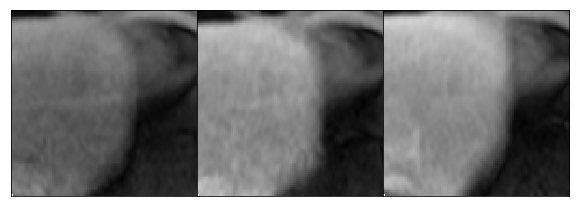

In [102]:
print(cropIs.shape)
vis.draw_slices(cropIs[15], normalize=[0,200])

### Paula

In [57]:
importlib.reload(drm)
drm.load_clinical_vars()

### Etiology

In [64]:
xls_path = r"Z:\Sophie\Ethiologyproject\HCC Etiology Project Master Spreadsheet.xlsx"

In [79]:
df = pd.read_excel(xls_path)

In [66]:
coords_df = pd.read_excel(xls_path, sheetname=1)

In [72]:
df = df.fillna(0)

In [84]:
df.loc[df["HepC_ViralLoad"] == '299.000 (3/28/2014) ', "HepC_ViralLoad"] = 299

In [119]:
df.loc[df["HepB_ViralLoad"] == '<5', "HepB_ViralLoad"] = 2.5
df.loc[df["HepB_ViralLoad"] == '<20', "HepB_ViralLoad"] = 10

In [141]:
df.loc[df["Tumor_Dx_MRI_Accession"]=="E100209927", "Alcohol"] = -1

In [85]:
len(df[(df["Include"]==1) & (df["HepC_ViralLoad"].astype(float) > 0)])

69

In [103]:
accnums = df[(df["Include"]==1) & (df["HepC_ViralLoad"].astype(float) > 0)]["Tumor_Dx_MRI_Accession"]

In [89]:
len(df[(df["Include"]==1) & (df["HepC_ViralLoad"].astype(float) == 0)])

43

In [100]:
accnums = df[(df["Include"]==1) & (df["HepC_ViralLoad"].astype(float) == 0)]["Tumor_Dx_MRI_Accession"]

In [ ]:
accnums = df[(df["Include"]==1) & (df["HepC_ViralLoad"].astype(float) == 0) & (df["Alcohol"].astype(float) == 1)]["Tumor_Dx_MRI_Accession"]

In [146]:
accnums = df[(df["Include"]==1) & (df["HepC_ViralLoad"].astype(float) == 0) & (df["NASH"].astype(float) == 1)]["Tumor_Dx_MRI_Accession"]

In [147]:
len(coords_df[coords_df["acc #"].isin(accnums)])

15

In [46]:
importlib.reload(vm)
vm.save_segs_as_imgs()

In [57]:
importlib.reload(vm)
vm.remove_lesion_id("5276207")

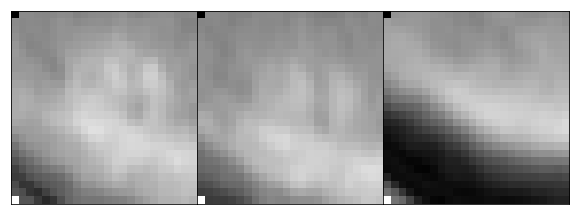

In [23]:
importlib.reload(vm)
vm.plot_check(1,"4262153_1");

In [62]:
importlib.reload(vm)
vm.save_seg_set(unaug=False, num_cores=2, overwrite=False)

### Semiauto rename

In [7]:
for fn in glob.glob(r"D:\Etiology\Imaging\*"):
    DCE = [x for x in os.listdir(join(fn, mod)) if ("vibe" in x or "post" in x) and x.endswith('.gz')]
    if len(DCE) > 0 and not exists(join(fn, mod, "mr30_equ.nii.gz")):
        DCE = sort_by_series_num([x for x in DCE if "min" not in x])

        print(fn, DCE[-1], DCE[0], sep="\n") #sort_by_series_num(PRE)[-1], 
        correct = input()
        if correct == "0":
            #os.rename(join(accnum, PRE[0]), join(accnum, "T1_BL"))
            os.rename(join(fn, mod, DCE[-1]), join(fn, mod, "mr30_equ.nii.gz"))
        elif correct == "q":
            break
        else:
            continue